## ML HW2 sample code

若有問題可直接寄信至助教信箱，環境部分推薦使用前述所提到之環境，若使用自己的電腦執行，請注意環境的相容性


#### Import packages

In [ ]:
import os
import random
import glob
import csv
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [ ]:
import gdown
url = "https://drive.google.com/u/0/uc?id=1jdh7w55GmpsGzw1y5Z7L0ylg1TACxjlt&export=download"
gdown.download(url)
!unzip 'ml2023-fall-hw2.zip'

Downloading...
From: https://drive.google.com/u/0/uc?id=1jdh7w55GmpsGzw1y5Z7L0ylg1TACxjlt&export=download
To: /content/ml2023-fall-hw2.zip
100%|██████████| 52.4M/52.4M [00:00<00:00, 193MB/s]


串流輸出內容已截斷至最後 5000 行。
  inflating: 2023HW2_7000/train/33887.jpg  
  inflating: 2023HW2_7000/train/33888.jpg  
  inflating: 2023HW2_7000/train/33889.jpg  
  inflating: 2023HW2_7000/train/33890.jpg  
  inflating: 2023HW2_7000/train/33891.jpg  
  inflating: 2023HW2_7000/train/33892.jpg  
  inflating: 2023HW2_7000/train/33893.jpg  
  inflating: 2023HW2_7000/train/33894.jpg  
  inflating: 2023HW2_7000/train/33895.jpg  
  inflating: 2023HW2_7000/train/33896.jpg  
  inflating: 2023HW2_7000/train/33897.jpg  
  inflating: 2023HW2_7000/train/33898.jpg  
  inflating: 2023HW2_7000/train/33899.jpg  
  inflating: 2023HW2_7000/train/33900.jpg  
  inflating: 2023HW2_7000/train/33901.jpg  
  inflating: 2023HW2_7000/train/33902.jpg  
  inflating: 2023HW2_7000/train/33903.jpg  
  inflating: 2023HW2_7000/train/33904.jpg  
  inflating: 2023HW2_7000/train/33905.jpg  
  inflating: 2023HW2_7000/train/33906.jpg  
  inflating: 2023HW2_7000/train/33907.jpg  
  inflating: 2023HW2_7000/train/33908.jpg  
  inflating

#### Set arguments and random seed

In [ ]:
TRA_PATH = '2023HW2_7000/train/'
TST_PATH = '2023HW2_7000/test/'
LABEL_PATH = '2023HW2_7000/train.csv'
DEVICE_ID = 0
SEED = 1428
NUM_ECPOCH = 250

torch.cuda.set_device(DEVICE_ID)
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

#### Process data

In [ ]:
def load_train_data(img_path, label_path, valid_ratio=0.12):
    train_label = pd.read_csv(label_path)['label'].values.tolist()
    train_image = [f'{img_path}/{i+7000}.jpg' for i in range(len(train_label)-1)]

    train_data = list(zip(train_image, train_label))
    random.shuffle(train_data)

    split_len = int(len(train_data) * valid_ratio)
    train_set = train_data[split_len:]
    valid_set = train_data[:split_len]

    return train_set, valid_set

def load_test_data(img_path):
    test_set = [f'{img_path}/{i}.jpg' for i in range(0,7000)]
    return test_set

def compute_statistics(dataset):
    data = []
    for (img_path, label) in dataset:
        data.append(np.array(Image.open(img_path)))
    data = np.array(data)
    return data.mean(), data.std()

In [ ]:
import torchvision.transforms.functional


train_set, valid_set = load_train_data(TRA_PATH, LABEL_PATH)
test_set = load_test_data(TST_PATH)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p = 0.5)

])
aug2 = transforms.Compose([
    transforms.RandomRotation(degrees=20, interpolation=transforms.InterpolationMode.BILINEAR)

])# do augmentation there
aug1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p = 1)

])
aug3 = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.3, p=1)
])

In [ ]:
k = pd.read_csv(LABEL_PATH)['label'].values
df = pd.DataFrame(k, columns = ['label'])
df['label'].value_counts()

3    7275
6    4955
4    4841
2    4136
0    4009
5    3221
1     450
Name: label, dtype: int64

#### Customize dataset

In [ ]:
from numpy.core.fromnumeric import shape
from sklearn import preprocessing
class FaceExpressionDataset(Dataset):
    def __init__(self, data, augment=None):
        self.data = data
        self.augment = augment
        print(len(self.data))

    def __len__(self):
        return len(self.data)

    def normalize(self, data):
        data = np.array(data)
        #print(data.shape)
        #print(data.std())
        if data.std() == 0:
          return torch.tensor(data)
        else:
          data = (data-data.mean())/data.std()
          return torch.tensor(data)


    def read_img(self, idx):
        img = Image.open(self.data[idx][0])

        img = torch.from_numpy(np.array(img)).float()


        img = img.unsqueeze(0).float()
        #img = transform(img)
        img = self.normalize(img)
        if idx < len(self.data) /4:
          img = img
        elif(idx >= len(self.data) /4) and (idx <  len(self.data) /2):
            img = aug1(img)
        elif(idx >= len(self.data) /2) and (idx < 3* len(self.data) /4):
            img = aug2(img)
        else:
          img = aug3(img)


        return img

    def __getitem__(self, idx):
        img = self.read_img(idx)
        label = self.data[idx][1]
        return img, label

class TestingDataset(Dataset):
    def __init__(self, data, augment=None):
        self.data = data
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def normalize(self, data):
        data = np.array(data)
        #print(data.std())
        if data.std() == 0:
          return torch.tensor(data)
        else:
          data = (data-data.mean())/data.std()
          return torch.tensor(data)


    def read_img(self, idx):
        img = Image.open(self.data[idx])
        img = torch.from_numpy(np.array(img)).float()
        img = img.unsqueeze(0).float()
        img = self.normalize(img)
        if idx < len(self.data) /4:
          img = img
        elif(idx >= len(self.data) /4) and (idx <  len(self.data) /2):
            img = aug1(img)
        elif(idx >= len(self.data) /2) and (idx < 3* len(self.data) /4):
            img = aug2(img)
        else:
          img = aug3(img)
        return img, self.data[idx].split('/')[-1][:-4]

    def __getitem__(self, idx):
        img, name = self.read_img(idx)

        return img, name

In [ ]:
train_set = train_set + train_set + train_set + train_set
valid_set = valid_set + valid_set + valid_set + valid_set

In [ ]:
test_set = test_set + test_set + test_set + test_set

In [ ]:
train_dataset = FaceExpressionDataset(train_set, transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

valid_dataset = FaceExpressionDataset(valid_set)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

test_dataset = TestingDataset(test_set)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

101680
13864


In [ ]:
train_dataset.read_img(0)

tensor([[[ 0.0252, -0.2277, -0.5103,  ...,  1.3194,  1.0814,  0.9029],
         [-0.2723, -0.3169, -0.5549,  ...,  1.4681,  1.2599,  1.0814],
         [-0.3764, -0.1533, -0.2128,  ...,  1.5425,  1.4384,  1.3491],
         ...,
         [-2.1615, -2.1913, -2.1913,  ..., -2.1020, -1.9830, -0.8227],
         [-1.8938, -2.1169, -2.1913,  ..., -1.9384, -1.8343, -1.0607],
         [-1.5814, -1.8938, -2.1318,  ..., -1.8789, -1.6111, -1.0310]]])

In [ ]:
i = 0
k = train_dataset.read_img(i)
print(k)
k = train_dataset.read_img(i+25420)
print(k)
k = train_dataset.read_img(i+50840)
print(k)
k = train_dataset.read_img(i+25420*3)
print(k)

tensor([[[ 0.0252, -0.2277, -0.5103,  ...,  1.3194,  1.0814,  0.9029],
         [-0.2723, -0.3169, -0.5549,  ...,  1.4681,  1.2599,  1.0814],
         [-0.3764, -0.1533, -0.2128,  ...,  1.5425,  1.4384,  1.3491],
         ...,
         [-2.1615, -2.1913, -2.1913,  ..., -2.1020, -1.9830, -0.8227],
         [-1.8938, -2.1169, -2.1913,  ..., -1.9384, -1.8343, -1.0607],
         [-1.5814, -1.8938, -2.1318,  ..., -1.8789, -1.6111, -1.0310]]])
tensor([[[ 0.9029,  1.0814,  1.3194,  ..., -0.5103, -0.2277,  0.0252],
         [ 1.0814,  1.2599,  1.4681,  ..., -0.5549, -0.3169, -0.2723],
         [ 1.3491,  1.4384,  1.5425,  ..., -0.2128, -0.1533, -0.3764],
         ...,
         [-0.8227, -1.9830, -2.1020,  ..., -2.1913, -2.1913, -2.1615],
         [-1.0607, -1.8343, -1.9384,  ..., -2.1913, -2.1169, -1.8938],
         [-1.0310, -1.6111, -1.8789,  ..., -2.1318, -1.8938, -1.5814]]])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0.

In [ ]:
i = 5
k = test_dataset.read_img(i)
print(k)
k = test_dataset.read_img(i+7000)
print(k)
k = test_dataset.read_img(i+14000)
print(k)
k = test_dataset.read_img(i+21000)
print(k)

(tensor([[[ 0.9951,  0.9951,  0.9951,  ...,  0.9951,  0.9951,  0.9951],
         [ 0.9951,  0.9951,  0.9951,  ...,  0.9951,  0.9951,  0.9951],
         [ 0.9951,  0.9951,  0.9951,  ...,  0.9951,  0.9951,  0.9951],
         ...,
         [-0.7329, -0.6395, -1.1066,  ..., -0.9548, -0.9548, -0.9431],
         [-0.7329, -0.9314, -1.3751,  ..., -1.0715, -0.9781, -0.9314],
         [-0.9898, -1.1066, -1.4335,  ..., -1.0949, -1.0715, -1.0248]]]), '5')
(tensor([[[ 0.9951,  0.9951,  0.9951,  ...,  0.9951,  0.9951,  0.9951],
         [ 0.9951,  0.9951,  0.9951,  ...,  0.9951,  0.9951,  0.9951],
         [ 0.9951,  0.9951,  0.9951,  ...,  0.9951,  0.9951,  0.9951],
         ...,
         [-0.9431, -0.9548, -0.9548,  ..., -1.1066, -0.6395, -0.7329],
         [-0.9314, -0.9781, -1.0715,  ..., -1.3751, -0.9314, -0.7329],
         [-1.0248, -1.0715, -1.0949,  ..., -1.4335, -1.1066, -0.9898]]]), '5')
(tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.9951,  0.4524,  0.0000],
         [ 0.4524,  0.5119,  0

In [ ]:
print(len(train_loader))

795


#### Define module class

In [ ]:
import torch.nn as nn

import torch.nn as nn

class FaceExpressionNet(nn.Module):
    def __init__(self):
        super(FaceExpressionNet, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256, eps=1e-05, affine=True),
            nn.LeakyReLU(negative_slope=0.02),
            nn.MaxPool2d((2, 2)),
            #nn.Dropout(0.1),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, eps=1e-05, affine=True),
            nn.LeakyReLU(negative_slope=0.02),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, eps=1e-05, affine=True),
            nn.LeakyReLU(negative_slope=0.02),
            nn.MaxPool2d((2, 2)),
            #nn.Dropout(0.1),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32, eps=1e-05, affine=True),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d((2, 2)),
            #nn.Dropout(0.1)
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 4 * 4, 7),  # Adjust the input size for the fully connected layer
        )

    def forward(self, x):
        # image size (64, 64)
        x = self.conv(x)  # (15, 15)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x



#### Define training and testing process

In [ ]:
def train(train_loader, model, loss_fn, use_gpu=True):
    model.train()
    train_loss = []
    train_acc = []
    for (img, label) in train_loader:
        if use_gpu:
            img = img.to(device)
            label = label.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            predict = torch.argmax(output, dim=-1)
            acc = np.mean((label == predict).cpu().numpy())
            train_acc.append(acc)
            train_loss.append(loss.item())
    print("Epoch: {}, train Loss: {:.4f}, train Acc: {:.4f}".format(epoch + 1, np.mean(train_loss), np.mean(train_acc)))
    return np.mean(train_loss), np.mean(train_acc)

def valid(valid_loader, model, loss_fn, use_gpu=True):
    model.eval()
    with torch.no_grad():
        valid_loss = []
        valid_acc = []
        for idx, (img, label) in enumerate(valid_loader):
            if use_gpu:
                img = img.to(device)
                label = label.to(device)
            output = model(img)
            loss = loss_fn(output, label)
            predict = torch.argmax(output, dim=-1)
            acc = (label == predict).cpu().tolist()
            valid_loss.append(loss.item())
            valid_acc += acc

        valid_acc = np.mean(valid_acc)
        valid_loss = np.mean(valid_loss)
        print("Epoch: {}, valid Loss: {:.4f}, valid Acc: {:.4f}".format(epoch + 1, valid_loss, valid_acc))
    return valid_acc, valid_loss

def save_checkpoint(valid_acc, acc_record, epoch, prefix='model'):
    # you can define the condition to save model :)
    if valid_acc >= np.mean(acc_record[-5:]):
        checkpoint_path = f'{prefix}.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print('model saved to %s' % checkpoint_path)

def better(acc_record):
    if max(acc_record) == acc_record[-1]: return True
    return False

In [ ]:
if __name__ == '__main__':
    model = FaceExpressionNet()
    if use_gpu:
        model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
    loss_fn = nn.CrossEntropyLoss()

    acc_record = []
    loss_record = []
    train_loss_record = []
    train_acc_record = []
    k = 0
    cou = 0
    max_acc =0.
    for epoch in range(NUM_ECPOCH):
        train_loss, train_acc = train(train_loader, model, loss_fn, use_gpu)
        valid_acc, valid_loss = valid(valid_loader, model, loss_fn, use_gpu=True)
        acc_record.append(valid_acc)
        loss_record.append(valid_loss)
        train_loss_record.append(train_loss)
        train_acc_record.append(train_acc)
        k = k+1;
        if(valid_acc > max_acc):
          cou = 0
          max_acc = valid_acc
          if better(acc_record):
            save_checkpoint(valid_acc, acc_record, epoch, prefix='model')
        else:
          cou = cou+1

        if(cou >=5):
          break


        print('########################################################')

Epoch: 1, train Loss: 1.3267, train Acc: 0.4928
Epoch: 1, valid Loss: 1.2182, valid Acc: 0.5422
model saved to model.pth
########################################################
Epoch: 2, train Loss: 1.1350, train Acc: 0.5725
Epoch: 2, valid Loss: 1.1277, valid Acc: 0.5784
model saved to model.pth
########################################################
Epoch: 3, train Loss: 1.0671, train Acc: 0.5988
Epoch: 3, valid Loss: 1.2333, valid Acc: 0.5485
########################################################
Epoch: 4, train Loss: 1.0199, train Acc: 0.6173
Epoch: 4, valid Loss: 1.1256, valid Acc: 0.5840
model saved to model.pth
########################################################
Epoch: 5, train Loss: 0.9850, train Acc: 0.6313
Epoch: 5, valid Loss: 1.1085, valid Acc: 0.5866
model saved to model.pth
########################################################
Epoch: 6, train Loss: 0.9573, train Acc: 0.6417
Epoch: 6, valid Loss: 1.0861, valid Acc: 0.5876
model saved to model.pth
##############

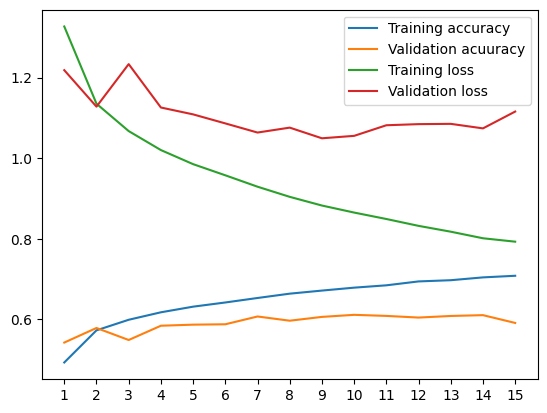

In [ ]:
from pickle import load
from matplotlib.pylab import plt
from numpy import arange
epochs = range(1, k+1)
plt.plot(epochs, train_acc_record, label='Training accuracy')
plt.plot(epochs, acc_record, label='Validation acuuracy')
plt.plot(epochs, train_loss_record, label='Training loss')
plt.plot(epochs, loss_record, label='Validation loss')
plt.xticks(arange(1, k+1, 1))
plt.legend(loc='best')
plt.show()

In [ ]:
model = FaceExpressionNet()
model.load_state_dict(torch.load('model.pth'))
model = model.cuda()
with torch.no_grad():
    model_result = []
    true_result = []
    for idx, (img, label) in enumerate(valid_loader):
      if use_gpu:
          img = img.to(device)
          label = label.to(device)
      output = model(img)
      predict = torch.argmax(output, dim=-1).tolist()
      model_result += predict
      true_result  += label.tolist()


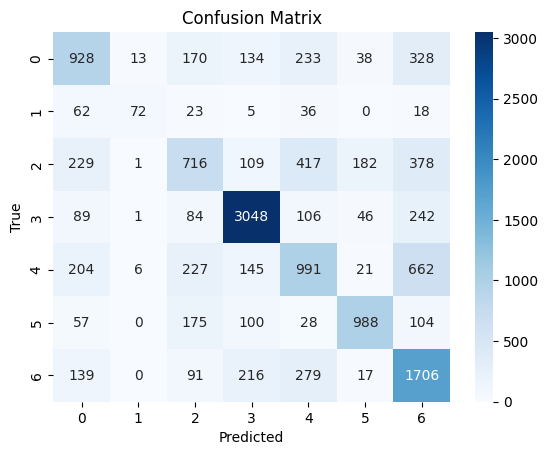

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(true_result, model_result)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3,4,5,6], yticklabels=[0,1,2,3,4,5,6])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from statistics import mode
def test(test_loader, model, file_name='predict.csv'):
    with torch.no_grad():
        predict_result = []
        predict_name = []
        for img, name in test_loader:
            if use_gpu:
                img = img.to(device)
            output = model(img)
            predict = torch.argmax(output, dim=-1).tolist()
            predict_result += predict
            predict_name += name
        for i in range(0,7000):
          predict_result[i] = mode([predict_result[i], predict_result[i+7000], predict_result[i+14000], predict_result[i+21000]])
        predict_result = predict_result[:7000]
        predict_name = predict_name[:7000]
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for id, r in zip(predict_name, predict_result):
            writer.writerow([id, r])

In [ ]:
del model
model = FaceExpressionNet()
model.load_state_dict(torch.load('model.pth'))
model = model.cuda()
test(test_loader, model)